
# Clustering

This notebook is dedicated to find clusters in a Hertzsprung-Russel diagram.

## Preprocessing
First of all we need to download the data.
As we're only interested in the core region, we apply a filter on the color-index: $E_{(B-V)} < 2.5$

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/astronexus/HYG-Database/master/hygdata_v3.csv"
hyg_data = pd.read_csv(url, usecols=['ci', 'absmag']).query('ci < 2.5')
print("Number of data points: ", len(hyg_data.index))

Number of data points:  117617


Now let's take a look at the data:

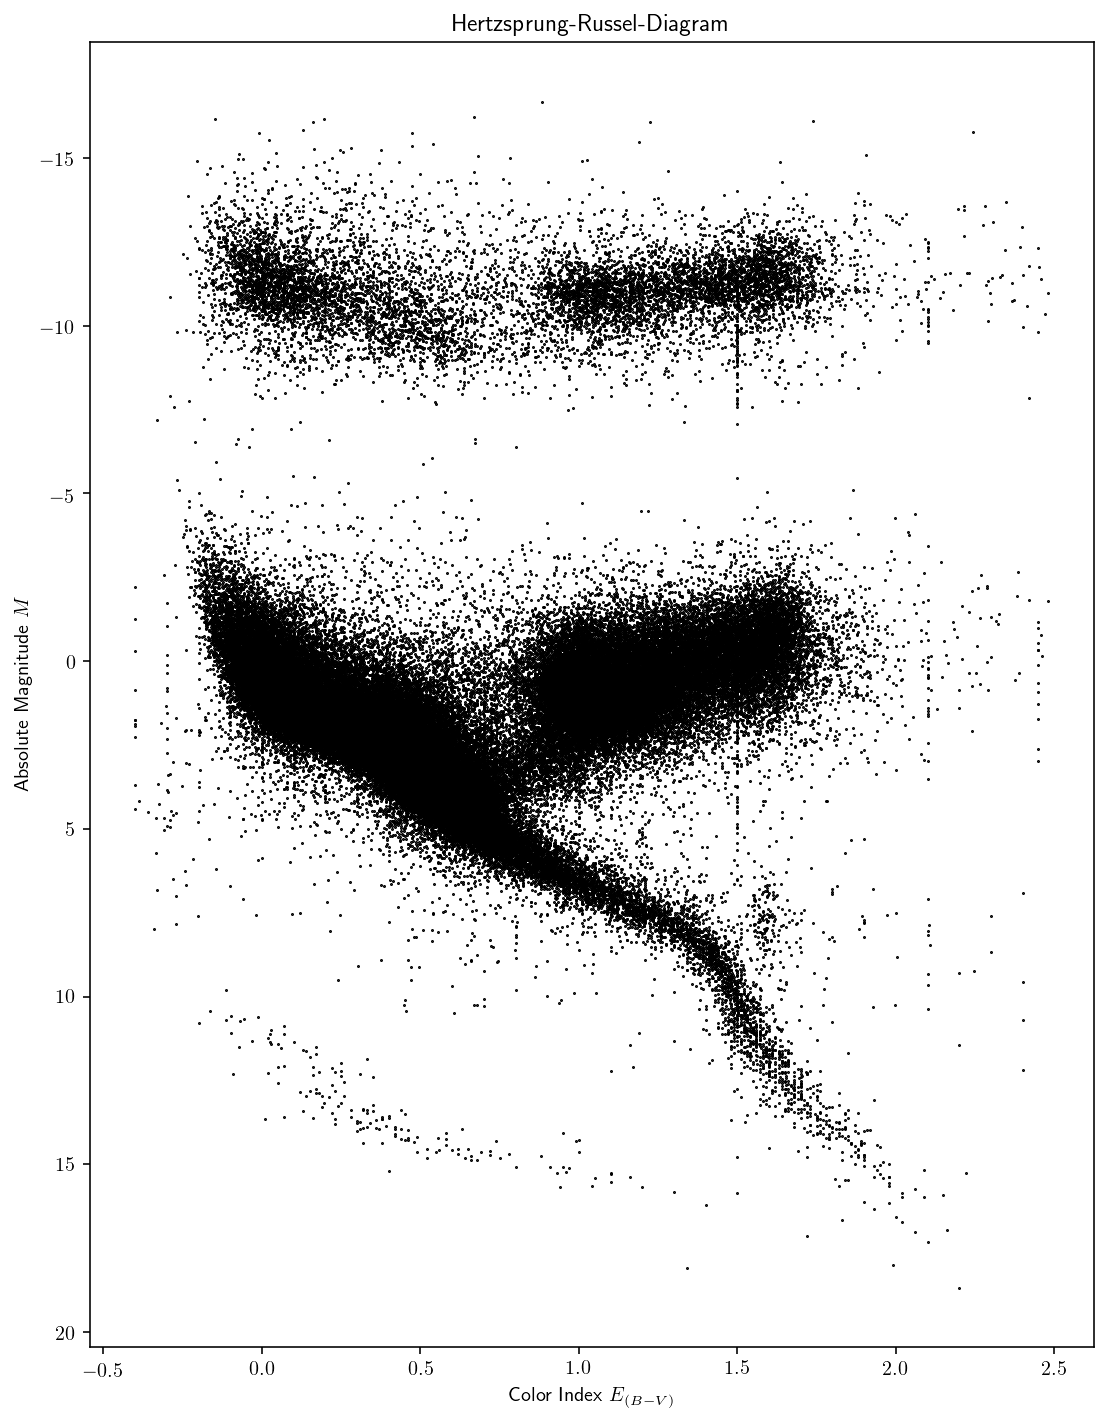

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.rcsetup.cycler(color=['r', 'b', 'm', 'c', 'g'])
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

plt.figure(figsize=(9, 12))
plt.plot(hyg_data['ci'], hyg_data['absmag'], 'k.', markersize=1)
ymin, ymax = plt.gca().get_ylim() # getting limits for y-axis
plt.ylim(ymax, ymin) # inverting y-axis
plt.title("Hertzsprung-Russel-Diagram")
plt.xlabel(r"Color Index $E_{(B-V)}$")
plt.ylabel(r"Absolute Magnitude $M$")
plt.show()

Before we go on with identifying clusters in the above data, we scale it. This has two reasons: 
1. Suitable scaling leads to equal weighting of color-index and magnitude *differences*
2. The choice of parameters for the DBSCAN algorithm will have nice values in reasonable order of magnitudes

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# scale and switch collumns to conform to the convention that the x axis is the 0th collumn
data = np.zeros(hyg_data.shape)
data.T[[0, 1]] = StandardScaler().fit_transform(hyg_data).T[[1, 0]]

For later use we implement our norm here, which shall be the Euclidean one.

In [4]:
def d(x, y):
    return np.sqrt(np.sum((x - y)**2))

Finally we're all set up and can begin to feed the data to some clustering algorithms.

## K-means algorithm

In the following sections we will attempt to find 2,3 and 5 distinct clusters.

In [5]:
n_clusters_lst = [2, 3, 5] 

### Homemade implementation

We begin with implementing our own version of the $K$-means algorithm.

**Note:** The following implementation is *not* optimized for performance. It shall rather point out the main parts, which need to be implemented in order to get a working version of the $K$-means algorithm.

In [6]:
import warnings as wrn

class K_means:
    def __init__(self, data):
        # private fields
        self.__data = data
        self.__assignments = None
        self.__means = None
        # public fields
        self.assignments = None
        self.means = None
        np.random.seed()
    
    # private methods
    def __objective_function(self):
        J = 0.
        for k, mean in enumerate(self.__means):
            J += np.sum((np.take(self.__data, np.nonzero(self.__assignments[:, k])[0], axis=0) - mean)**2)
        return J
        
    def __expectation_step(self):
        for k in range(len(self.__means)):
            
            N_k = np.count_nonzero(self.__assignments[:, k])
            
            if N_k == 0:
                wrn.warn("A cluster has become empty. The initial values of the cluster means are choosen poorely."
                         , RuntimeWarning)
                return False
            else:
                self.__means[k] = 1./N_k * np.sum(
                    np.take(self.__data, np.nonzero(self.__assignments[:, k])[0], axis=0), axis=0)
                return True # success
                
    def __maximization_step(self):
        updated_assignments = np.zeros(self.__assignments.shape, dtype=np.int8)
        for i, x in enumerate(self.__data):
            # calculate squared distances of a point to each of the cluster centers
            d_x_mu = np.array([np.sum((x - mu)**2) for mu in self.__means])
            k_min = np.argmin(d_x_mu)
            if type(k_min) is np.ndarray and len(k_min) > 1:
                wrn.warning("A data point is closest to more than one cluster mean. Taking the first one."
                            , RuntimeWarning)
                k_min = k_min[0]
            updated_assignments[i, k_min] = 1
        if np.array_equal(self.__assignments, updated_assignments):
            return True # converged
        else:
            self.__assignments = updated_assignments
            return False # not converged
            
    # public methods    
    def run(self, n_clusters, n_init=10):
        
        # initialize objective function
        J_min = np.inf
        
        for i_init in range(n_init):
            
            aborted = True
            while aborted:
                print("Random initialization of cluster means", i_init+1, "/", n_init)
                # container for the cluster assignments
                self.__assignments = np.zeros((len(self.__data), n_clusters), dtype=np.int8)

                # initialize with random means
                self.__means = np.zeros((n_clusters, self.__data.shape[1]))
                # generate random position in each feature space 
                for i_ft in range(self.__data.shape[1]):
                    self.__means[:, i_ft] = np.random.uniform(low=np.amin(self.__data[:, i_ft])
                                                              , high=np.amax(self.__data[:, i_ft])
                                                              , size=n_clusters)
                it = 0
                # main loop
                while not self.__maximization_step():
                    if not self.__expectation_step():
                        print("Aborting for this set of initial values for the cluster means.")
                        aborted = True 
                        break
                    else: aborted = False
                    it +=1
                
            J = self.__objective_function()
            print("Objective function J =", J)
            print("Total number of iterations:", it)
            
            # store assignments and cluster means with lowest J
            if J < J_min:
                self.assignments = self.__assignments
                self.means = self.__means
                J_min = J
    
    def plot_2d(self, ax):
        # plot data with clusters in different colors
        for k in range(len(self.means)):
            cluster_data = np.take(self.__data, np.nonzero(self.assignments[:, k])[0], axis=0)
            ax.plot(cluster_data[:, 0], cluster_data[:, 1], '.', markersize=1)
        # plot cluster means
        ax.plot(self.means[:,0], self.means[:,1], 'kx', markersize=8, mew=3)

Done that, let's try it out and make some fancy plots!

Clustering with 2 distinct clusters ...
Random initialization of cluster means 1 / 5
Objective function J = 203791.210506
Total number of iterations: 11
Random initialization of cluster means 2 / 5
Objective function J = 173050.007982
Total number of iterations: 7
Random initialization of cluster means 3 / 5
Objective function J = 195470.906113
Total number of iterations: 4
Random initialization of cluster means 4 / 5
Objective function J = 197362.006198
Total number of iterations: 4
Random initialization of cluster means 5 / 5
Objective function J = 154241.636421
Total number of iterations: 9
CPU times: user 1min 18s, sys: 658 ms, total: 1min 19s
Wall time: 1min 21s
...done.
Clustering with 3 distinct clusters ...
Random initialization of cluster means 1 / 5
Objective function J = 221288.062427
Total number of iterations: 4
Random initialization of cluster means 2 / 5
Objective function J = 194907.017451
Total number of iterations: 6
Random initialization of cluster means 3 / 5
Object

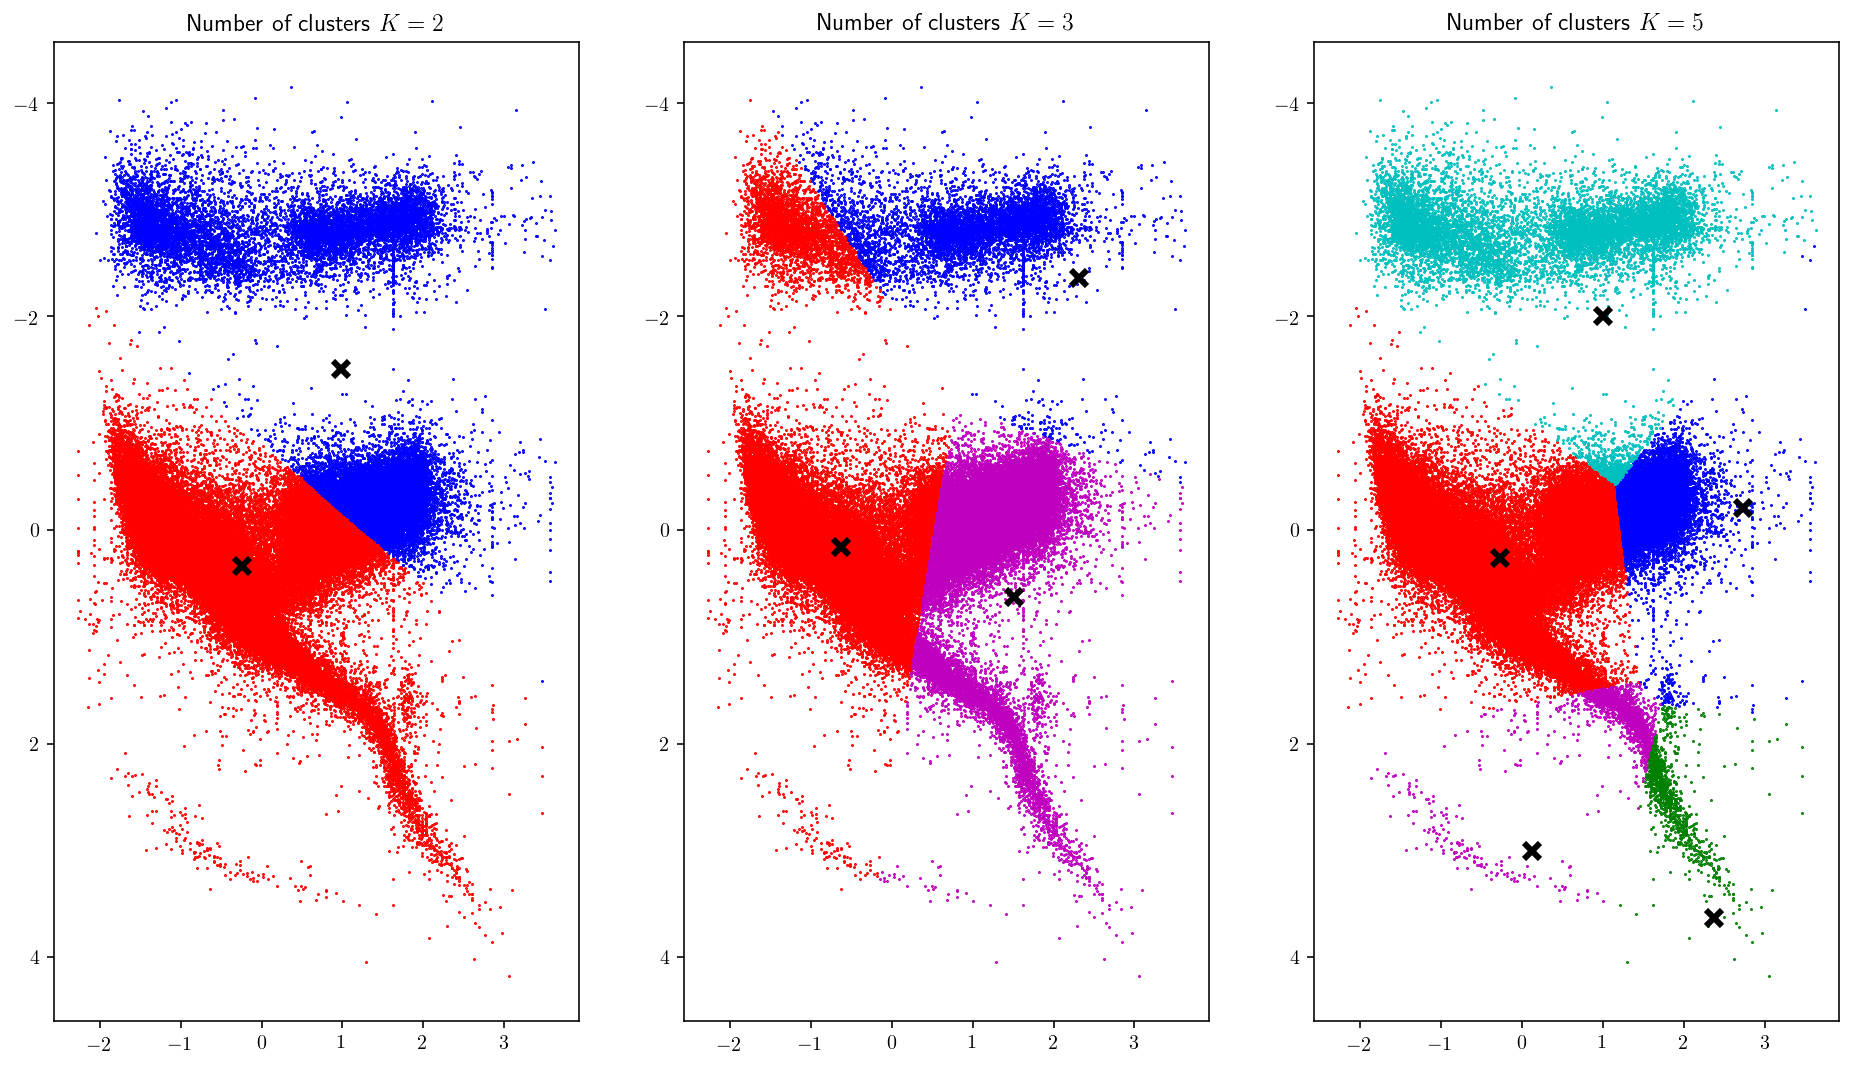

In [7]:
# initialize our algorithm class with our given data
k_means = K_means(data)

fig, axs = plt.subplots(nrows=1, ncols=len(n_clusters_lst), figsize=(16, 9))
for i_n_clusters, n_clusters in enumerate(n_clusters_lst):
    print("Clustering with", n_clusters, "distinct clusters ...")
    %time k_means.run(n_clusters, n_init=5) # run the algorithm
    k_means.plot_2d(axs[i_n_clusters]) # plotting
    print("...done.")
    ymin, ymax = axs[i_n_clusters].get_ylim() # getting limits for y-axis
    axs[i_n_clusters].set_ylim([ymax, ymin]) # inverting y-axis
    axs[i_n_clusters].title.set_text(r"Number of clusters $K = " + str(n_clusters) + r"$")
plt.show()

The cluster means $\mu_k$ are displayed as black crosses.

### Using sklearn


Clustering with 2 distinct clusters ...
CPU times: user 8.55 s, sys: 2.87 s, total: 11.4 s
Wall time: 9.15 s
...done. Final value of the objective function: 144913.229048
Clustering with 3 distinct clusters ...
CPU times: user 11.2 s, sys: 3.29 s, total: 14.4 s
Wall time: 11.9 s
...done. Final value of the objective function: 74054.0748363
Clustering with 5 distinct clusters ...
CPU times: user 20.8 s, sys: 4.09 s, total: 24.9 s
Wall time: 20.7 s
...done. Final value of the objective function: 42047.0546579


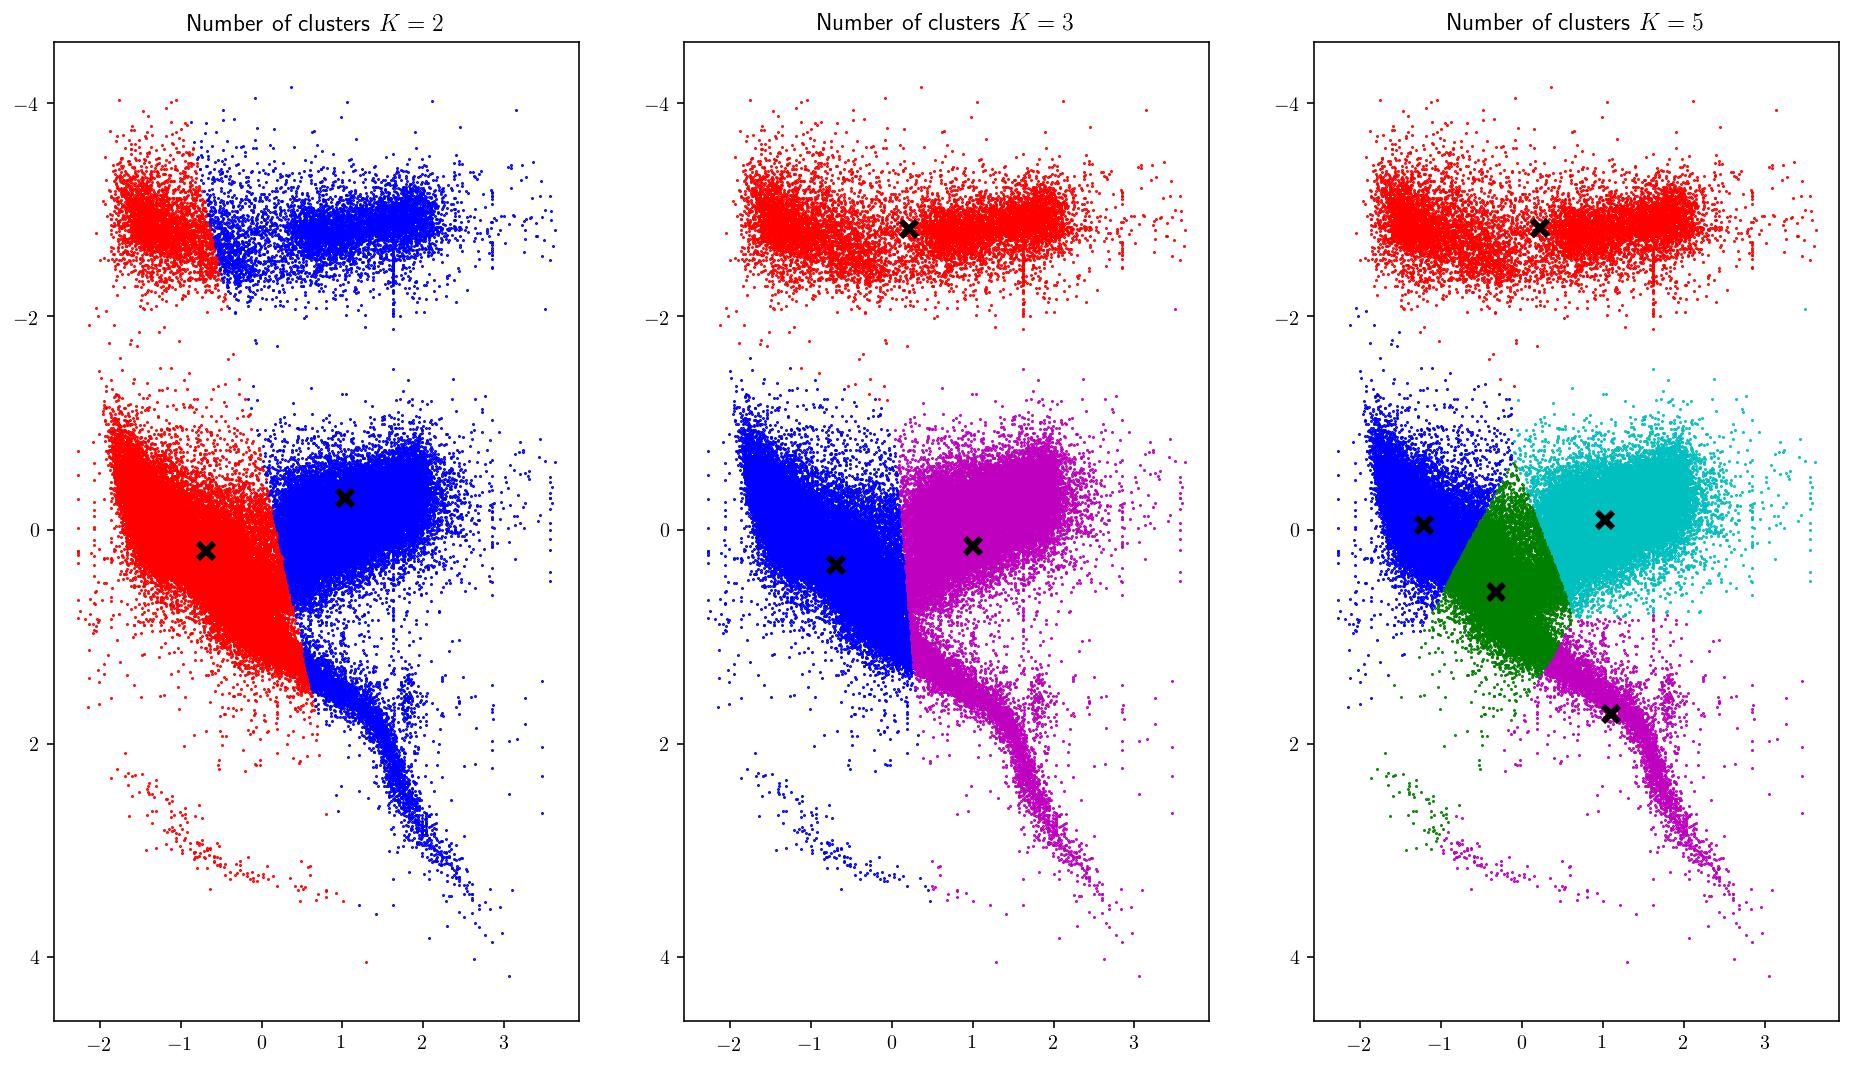

In [8]:
from sklearn.cluster import k_means as sklearn_k_means

fig, axs = plt.subplots(nrows=1, ncols=len(n_clusters_lst), figsize=(16, 9))
for i_n_clusters, n_clusters in enumerate(n_clusters_lst):
    print("Clustering with", n_clusters, "distinct clusters ...")
    means, assignments, J = %time sklearn_k_means(data, n_clusters=n_clusters, init='random' \
                                                  , n_init=50, algorithm='full', tol=0.)
    print("...done. Final value of the objective function:", J)
    # feed the results to our K_means class in order to use their plot function
    k_means.means = means
    # convert the returned assignment into our format
    k_means.assignments = np.zeros((len(data), n_clusters), dtype=np.int8)
    for i, assignment in enumerate(assignments):
        k_means.assignments[i, assignment] = 1
    k_means.plot_2d(axs[i_n_clusters]) # plotting
    ymin, ymax = axs[i_n_clusters].get_ylim() # getting limits for y-axis
    axs[i_n_clusters].set_ylim([ymax, ymin]) # inverting y-axis
    axs[i_n_clusters].title.set_text(r"Number of clusters $K = " + str(n_clusters) + r"$")
plt.show()

### Remarks

Unsurprisingly sklearn's implementation is much more efficient and we can easily run the algorithm with $n_{\text{init}} = 50$ without having to wait a long time until it's finished. We can also see that the results with $n_{\text{init}} = 5$ differ with every try and the objective function $J$ has generally a higher value as in the case where we re-run the algorithm a lot more times with different initializations for the cluster means $\mu_k$. Therefore we can state that in order to find a *global* minimum, we need to initialize the algorithm many times. In the case of $n_{\text{init}} = 50$ we get the same result each time, so we assume that we've found the *global* minimum.

## DBSCAN algorithm

Let's proceed to a density-based approach. 

### Homemade implementation

As for the $K$-means algorithm, we begin by implementing a simple version of the algorithm by ourselves.

**Note:** Again, the following implementation of the DBSCAN algorithm is *not* optimized for performance. 

In [9]:
class DBSCAN:
    def __init__(self, data, norm=d):
        # private fields
        self.__data = data
        self.__eps = 0.1
        self.__minPts = 10
        self.__visited = None
        self.__norm = norm
        # public fields
        self.clusters = None
    
    # private methods    
    def __is_core_point(self, x):
        # get all density reachable points
        neighbors = [i for i, y in enumerate(self.__data) if self.__norm(x, y) < self.__eps]
        if len(neighbors) >= self.__minPts:
            return True, neighbors
        else:
            return False, neighbors    

    def __get_neighbors_of_core_points(self, points_i):
        neighbors_of_core_points = [] # return value
        for i in points_i:
            is_core_point, neighbors = self.__is_core_point(self.__data[i])
            if is_core_point: 
                # append new neighbors
                neighbors_of_core_points += [nghbr for nghbr in neighbors if nghbr not in neighbors_of_core_points]
        return neighbors_of_core_points
        
    def __get_density_reachable_points(self, core_point, neighbors):
        density_reachable_points = [core_point] # return value 
        while len(neighbors):
            density_reachable_points += neighbors
            neighbors_of_core_points = self.__get_neighbors_of_core_points(neighbors)
            neighbors = [i for i in neighbors_of_core_points if i not in density_reachable_points]
        return np.array(density_reachable_points)
        
    def __visit_point(self, i, x):
        self.__visited[i] = 1
        is_core_point, neighbors = self.__is_core_point(x)
        if is_core_point: 
            print("A core point has been found. Creating cluster.")
            self.clusters[0].remove(i)
            density_reachable_points = self.__get_density_reachable_points(i, neighbors)
            self.__visited[density_reachable_points] = 1 # mark all points in cluster as visited
            self.clusters.append(density_reachable_points) # store cluster
            print(len(self.clusters[-1]), "points have been assigned to cluster", len(self.clusters)-1)
        
    # public methods
    def run(self, eps, minPts):
        self.__eps = eps
        self.__minPts = minPts
        self.__visited = np.zeros(len(self.__data), dtype=np.int8)
        self.clusters = [[i for i in range(len(self.__data))]] # first "cluster" holds unassigned points
        
        # main loop 
        print("Clustering with eps =", self.__eps, "and minPts =", self.__minPts, "...")
        for i, x in enumerate(self.__data):
            if not self.__visited[i]:
                self.__visit_point(i, x)
        # convert python built in list to numpy array
        self.clusters[0] = np.array(self.clusters[0])
        self.clusters = np.array(self.clusters)
        print("...done.")
                
    def plot_2d(self, ax, markersize=3):
        # plot unassigned points
        unassigned_points = np.take(self.__data, self.clusters[0], axis=0) 
        ax.plot(unassigned_points[:, 0], unassigned_points[:, 1], 'k.', markersize=markersize)
        for cluster in self.clusters[1:]:
            cluster_points = np.take(self.__data, cluster, axis=0) 
            ax.plot(cluster_points[:, 0], cluster_points[:, 1], '.', markersize=markersize)

Because the implementation above is not focussed on performance, we apply the above algorithm only on a subset of the data in order to avoid elongated runtimes.

In [10]:
# initialize algorithm class with a subset of the data
dbscan = DBSCAN(data[:5000])
params_lst = [[0.4, 100], [0.3, 200], [0.3, 30]] # array of [eps, minPts]

All set up, let's give it a try.

Clustering with eps = 0.4 and minPts = 100 ...
A core point has been found. Creating cluster.
4498 points have been assigned to cluster 1
A core point has been found. Creating cluster.
116 points have been assigned to cluster 2
...done.
CPU times: user 4min 36s, sys: 1.78 s, total: 4min 38s
Wall time: 4min 56s
Clustering with eps = 0.3 and minPts = 200 ...
A core point has been found. Creating cluster.
2718 points have been assigned to cluster 1
A core point has been found. Creating cluster.
1600 points have been assigned to cluster 2
...done.
CPU times: user 4min 30s, sys: 2.5 s, total: 4min 32s
Wall time: 4min 52s
Clustering with eps = 0.3 and minPts = 30 ...
A core point has been found. Creating cluster.
4582 points have been assigned to cluster 1
A core point has been found. Creating cluster.
213 points have been assigned to cluster 2
A core point has been found. Creating cluster.
133 points have been assigned to cluster 3
...done.
CPU times: user 3min 51s, sys: 1.85 s, total: 3min

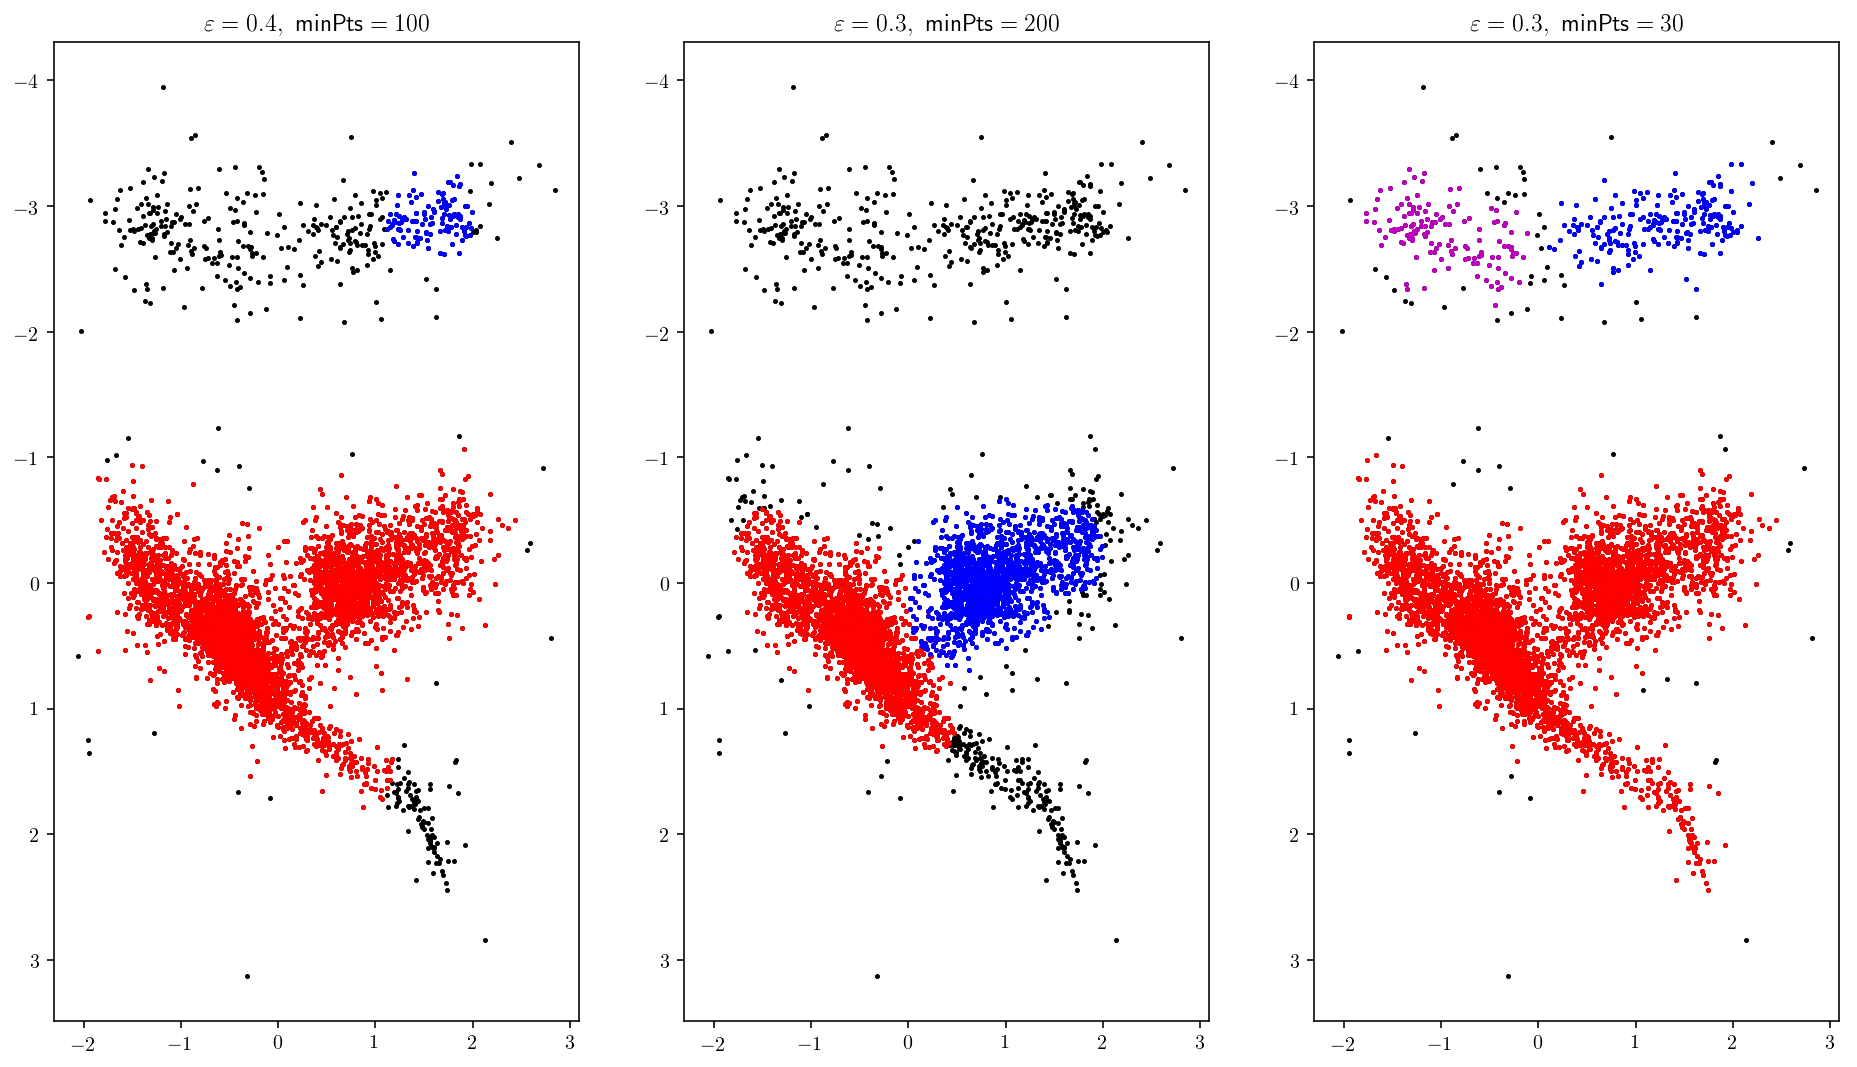

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=len(params_lst), figsize=(16, 9))
for i_params, params in enumerate(params_lst):
    %time dbscan.run(params[0], params[1]) # run the algorithm
    dbscan.plot_2d(axs[i_params]) # plotting
    ymin, ymax = axs[i_params].get_ylim() # getting limits for y-axis
    axs[i_params].set_ylim([ymax, ymin]) # inverting y-axis
    axs[i_params].title.set_text(r"$\varepsilon = " + str(params[0]) 
                                     + r", \ \text{minPts} = " + str(params[1]) + r"$")
plt.show()

The unassigned points, which are considered noise, are colored in black, while each cluster is displayed in a different color.

### Using sklearn

In order to check if our implementation yields reasonable results, we start by feeding the subset of our data to the DBSCAN alghorithm included in the sklearn package.

Clustering with eps = 0.4 and minPts = 100 ...
CPU times: user 114 ms, sys: 24.2 ms, total: 138 ms
Wall time: 141 ms
Total number of clusters found 2
...done.
Clustering with eps = 0.3 and minPts = 200 ...
CPU times: user 93.6 ms, sys: 7.24 ms, total: 101 ms
Wall time: 101 ms
Total number of clusters found 2
...done.
Clustering with eps = 0.3 and minPts = 30 ...
CPU times: user 84.4 ms, sys: 3.47 ms, total: 87.8 ms
Wall time: 88 ms
Total number of clusters found 3
...done.


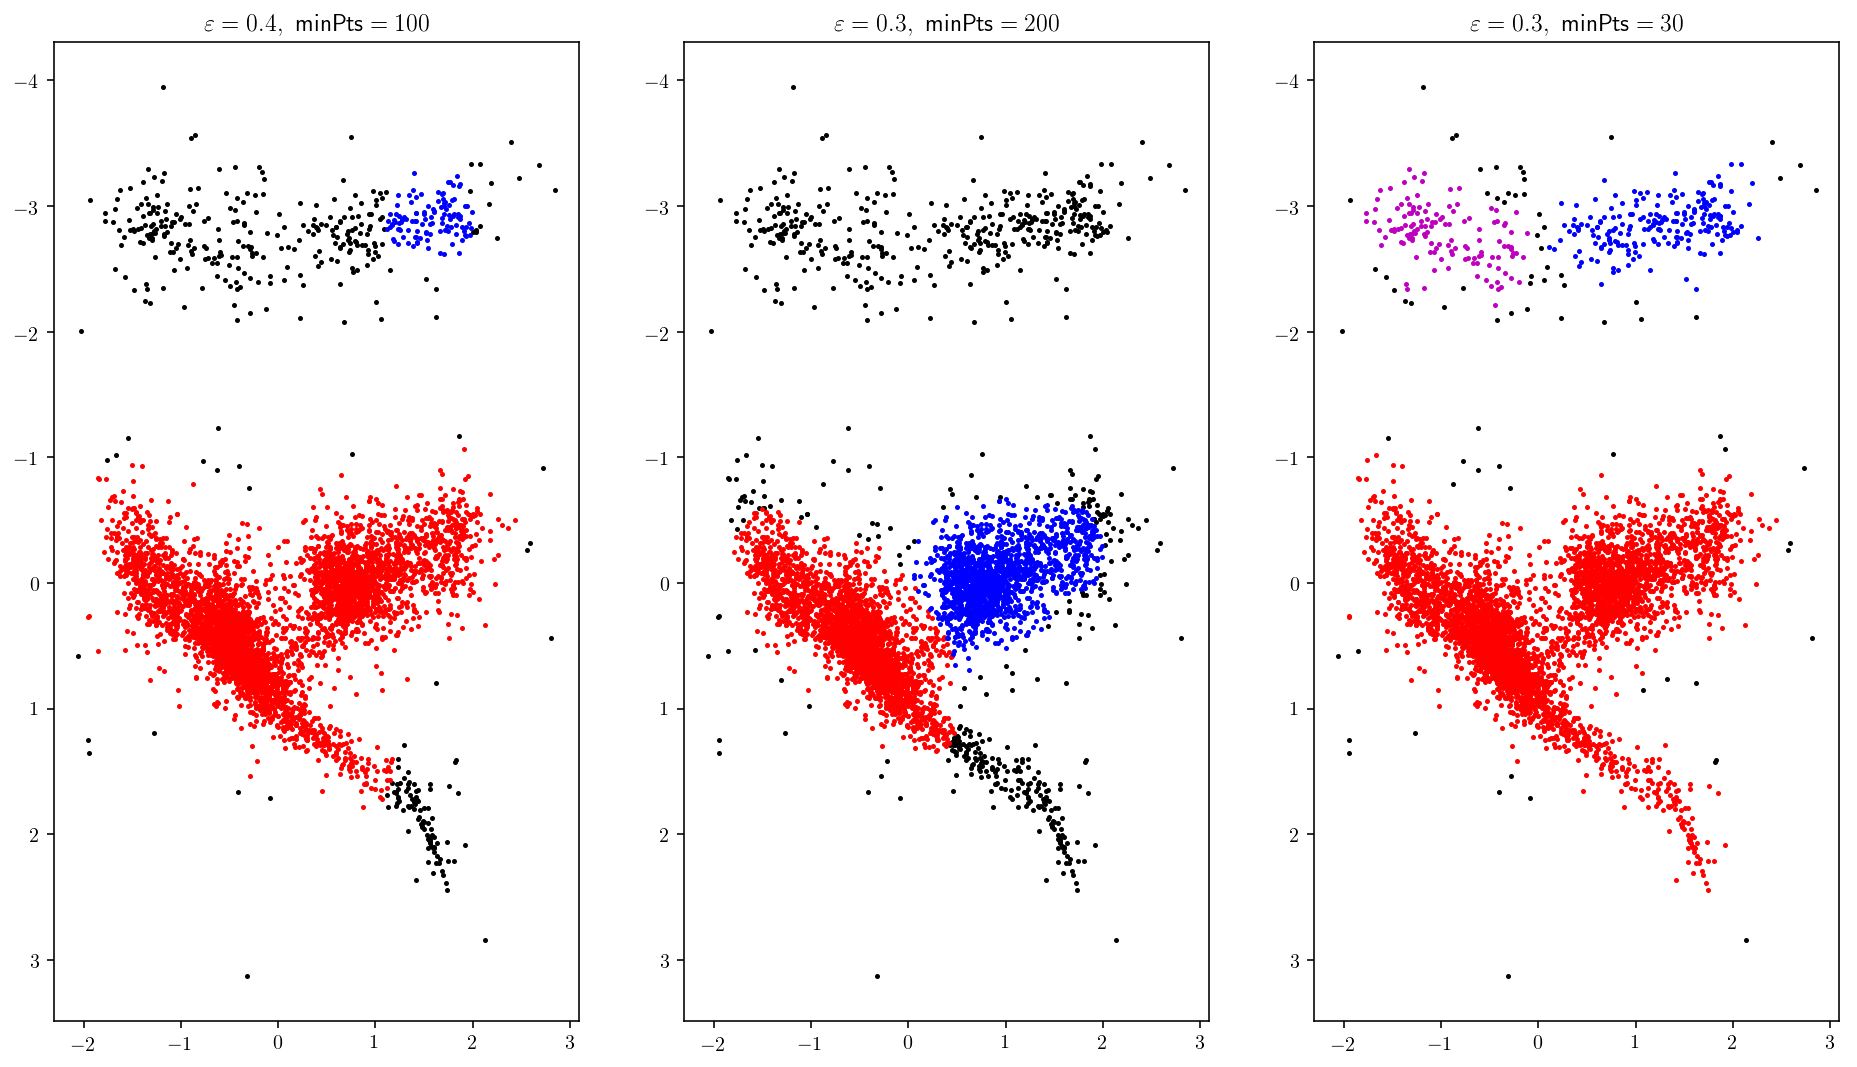

In [12]:
from sklearn.cluster import DBSCAN as sklearn_DBSCAN

fig, axs = plt.subplots(nrows=1, ncols=len(params_lst), figsize=(16, 9))
for i_params, params in enumerate(params_lst):
    dbscan_model = sklearn_DBSCAN(eps=params[0], min_samples=params[1], metric='euclidean') # initialize the model
    print("Clustering with eps =", params[0], "and minPts =", params[1], "...")
    %time dbscan_model.fit(data[:5000]) # run the algorithm
    print("Total number of clusters found", len(np.unique(dbscan_model.labels_)) - 1)
    print("...done.")
    # convert result to our format
    dbscan.clusters = [[] for _ in range(len(np.unique(dbscan_model.labels_)))]
    for i, cluster in enumerate(dbscan_model.labels_):
        if cluster == -1:
            cluster = 0 
        else:
            cluster = cluster+1
        dbscan.clusters[cluster].append(i)        
    dbscan.plot_2d(axs[i_params]) # plotting
    ymin, ymax = axs[i_params].get_ylim() # getting limits for y-axis
    axs[i_params].set_ylim([ymax, ymin]) # inverting y-axis
    axs[i_params].title.set_text(r"$\varepsilon = " + str(params[0]) 
                                     + r", \ \text{minPts} = " + str(params[1]) + r"$")
plt.show()

As we can see, the results are the same as generated by our homemade implementation, yet again sklearn's implementation is much faster. So now let's cluster all of our input data.

Clustering with eps = 0.3 and minPts = 200 ...
CPU times: user 29.4 s, sys: 42.8 s, total: 1min 12s
Wall time: 1min 40s
Total number of clusters found 2
...done.
Clustering with eps = 0.1 and minPts = 50 ...
CPU times: user 5.62 s, sys: 1.23 s, total: 6.86 s
Wall time: 6.97 s
Total number of clusters found 4
...done.
Clustering with eps = 0.2 and minPts = 20 ...
CPU times: user 14.8 s, sys: 9.8 s, total: 24.6 s
Wall time: 27.3 s
Total number of clusters found 3
...done.


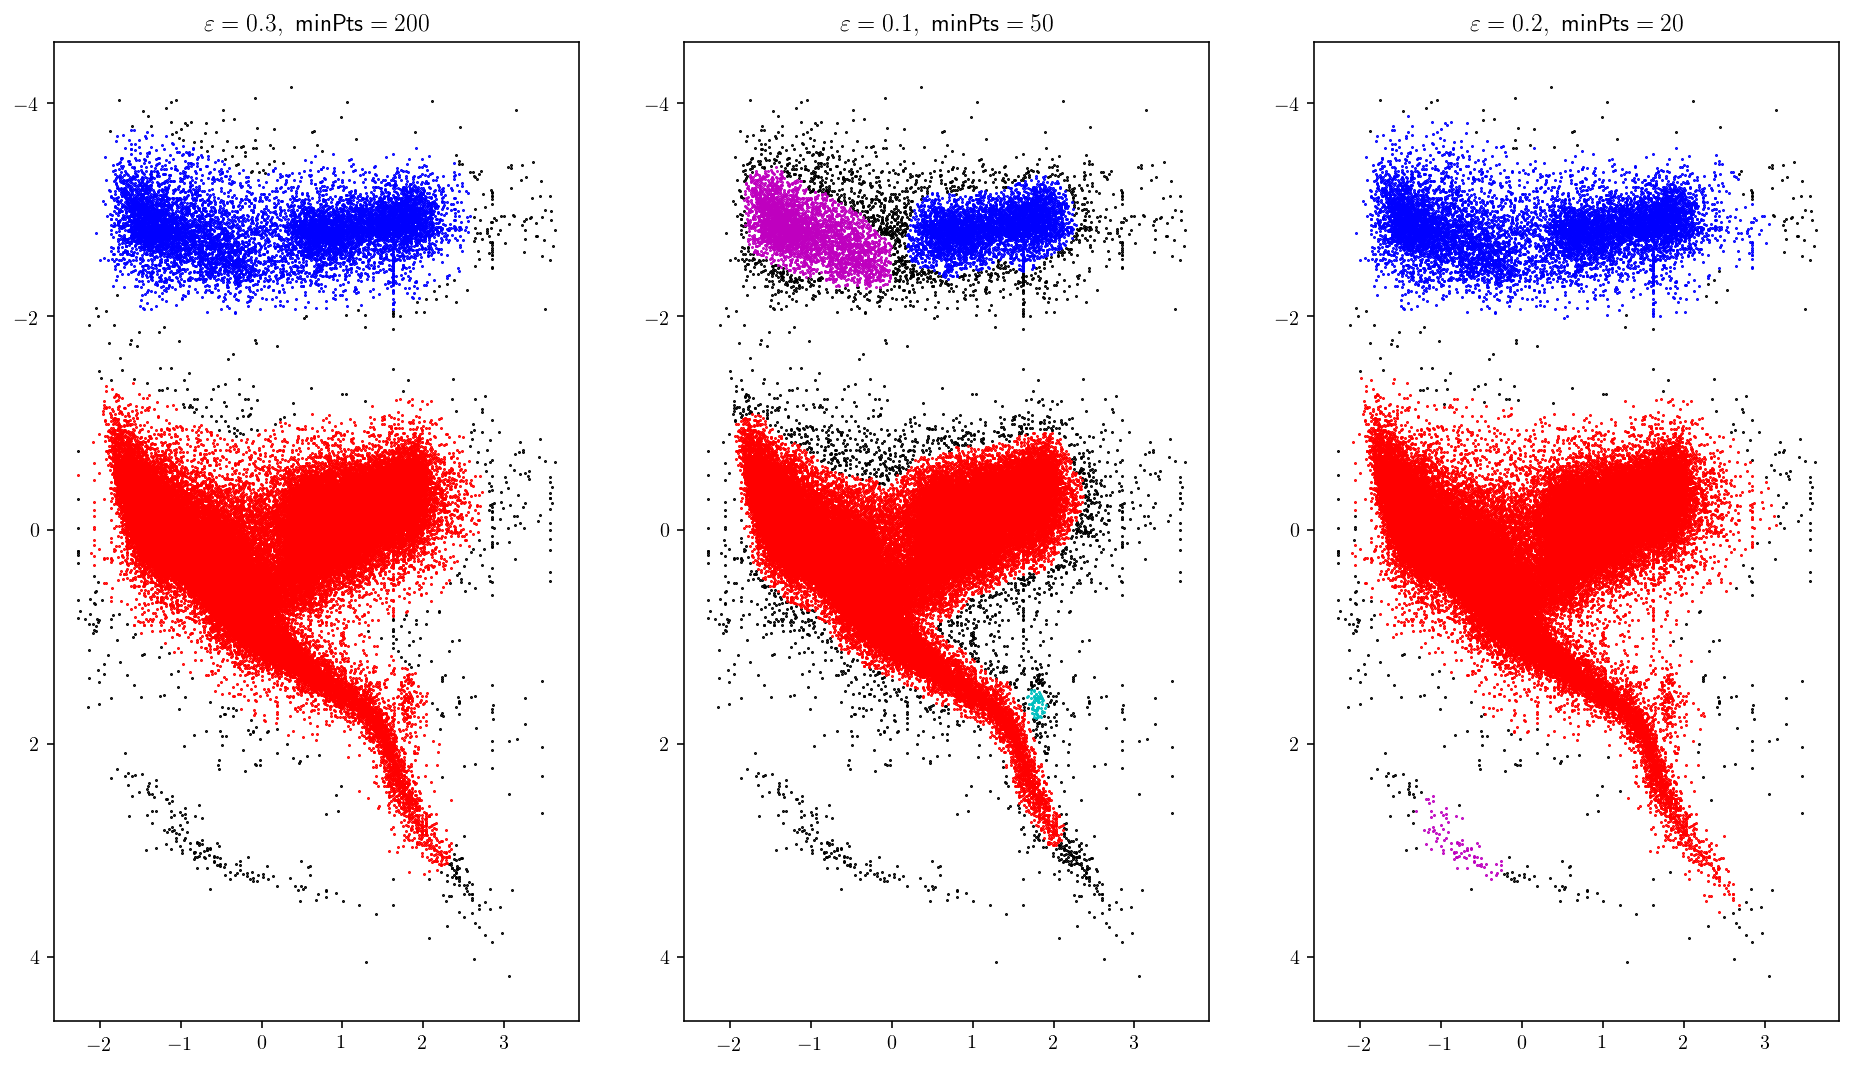

In [13]:
dbscan = DBSCAN(data) # initialize our class with all the data in order to use it for plotting
params_lst_full_data = [[0.3, 200], [0.1, 50], [0.2, 20]] # array of [eps, minPts]

fig, axs = plt.subplots(nrows=1, ncols=len(params_lst_full_data), figsize=(16, 9))
for i_params, params in enumerate(params_lst_full_data):
    dbscan_model = sklearn_DBSCAN(eps=params[0], min_samples=params[1], metric='euclidean') # initialize the model
    print("Clustering with eps =", params[0], "and minPts =", params[1], "...")
    %time dbscan_model.fit(data) # run the algorithm
    print("Total number of clusters found", len(np.unique(dbscan_model.labels_)) - 1)
    print("...done.")
    # convert result to our format
    dbscan.clusters = [[] for _ in range(len(np.unique(dbscan_model.labels_)))]
    for i, cluster in enumerate(dbscan_model.labels_):
        if cluster == -1:
            cluster = 0 
        else:
            cluster = cluster+1
        dbscan.clusters[cluster].append(i)        
    dbscan.plot_2d(axs[i_params], markersize=1) # plotting
    ymin, ymax = axs[i_params].get_ylim() # getting limits for y-axis
    axs[i_params].set_ylim([ymax, ymin]) # inverting y-axis
    axs[i_params].title.set_text(r"$\varepsilon = " + str(params[0]) 
                                     + r", \ \text{minPts} = " + str(params[1]) + r"$")
plt.show()

## Summary

Finally we can state, that clustering the Hertzsprung-Russel data is not as easy for an algorithm as for humans, because there are multiple clusters with significantly different densities and the data can poorely generated from gaussian mixtures, which is why the DBSCAN algorithm performs better than the $K$-means algorithm.

To conclude this notebook, let's take a look at a fancy plot, where the clusters are shown as assigned by scientists.

![Hertzsprung-Russel-Diagram](https://raw.githubusercontent.com/zonination/h-r-diagram/master/twinkle.gif)

## Sources

The data has been taken from [HYG-Database](https://github.com/astronexus/HYG-Database) and inspiration was found at [h-r-diagram](https://github.com/zonination/h-r-diagram). In additiuon to that, [sklearn's documentation on clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) has been consulted. The homemade implementations of the algorithms are based on their descriptions in [A high-bias, low-variance introduction to Machine Learning for physicists](https://arxiv.org/abs/1803.08823)
